In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torch_geometric.loader import DataLoader



%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
print(torch.__version__)

1.13.1


In [3]:
print(torch_geometric.__version__)

2.1.0


In [4]:
def correlation_matrix(size, corr):
    corr_matrix = np.zeros((size,size))
    cont = 0

    for i in range(size):
        for j in range(i, size):
            if i == j:
                corr_matrix[i,j] = 0#float('nan')


            else:
                corr_matrix[i,j] = corr[cont]
                corr_matrix[j,i] = corr[cont]
                cont += 1 
    return corr_matrix

In [5]:
def import_data(fisher):
    if fisher == True:
        df = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/corr_matrices_fisher200.csv',index_col=['Institution','Subject'])
        phenotypic = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/phenotypic200.csv',index_col=['Institution','Subject'])
    else:
        df = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/corr_matrices200.csv',index_col=['Institution','Subject','Run'])
        phenotypic = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/phenotypic200.csv',index_col=['Institution','Subject'])
    return df,phenotypic

In [6]:
df, phenotypic = import_data(fisher=True)
df = df.join(pd.DataFrame(phenotypic.Age), how='left')
df = df.join(pd.DataFrame(phenotypic['ADHD Measure']), how='left')
df = df.join(pd.DataFrame(phenotypic['Gender']), how='left')

df = ((df.reset_index()).drop(columns=['Institution', 'Subject'])).dropna(subset=[str(x) for x in range(0,17954)])
df = df.dropna(axis=0, subset=['Gender'])

# Real test set
TEST =  df.iloc[-50:]

df = df.iloc[:-50]

# Labels
y = (df.Gender).apply(lambda x: int(x))

# Remove from Fisher-space
X = np.tanh(df.iloc[:,:-3])

#X = (df.iloc[:,:-3])

In [7]:
print(' 0 = {:.2f}% \n'.format(y.value_counts()[0]/len(y)), '1 = {:.2f}%'.format(y.value_counts()[1]/len(y)))

 0 = 0.37% 
 1 = 0.63%


In [8]:
from sklearn.model_selection import train_test_split

# Split train and validation set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, shuffle=True)

In [9]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_test, y_test)
dummy_clf.predict(X_test)
print('Dummy_classifier acc {:.2f}'.format(dummy_clf.score(X_test,y_test)))

Dummy_classifier acc 0.63


In [10]:
A = correlation_matrix(190,X_train.iloc[-1])


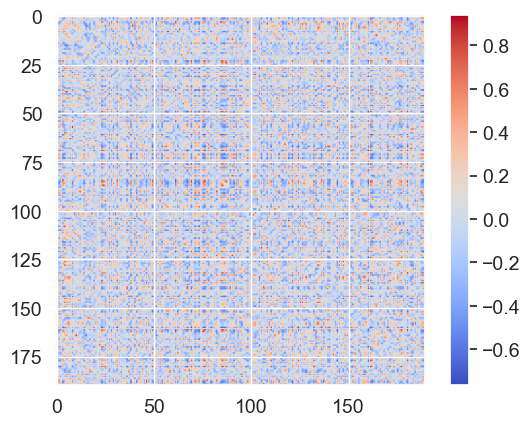

In [11]:
plt.imshow(A)
plt.colorbar()
plt.show()

## K-NN for selecting edges

In [12]:
from scipy.sparse import coo_matrix

def compute_KNN_graph(matrix, k_degree=10):
    """ Calculate the adjacency matrix from the connectivity matrix."""

    matrix = np.abs(matrix)
    idx = np.argsort(-matrix)[:, 0:k_degree]
    matrix.sort()
    matrix = matrix[:, ::-1]
    matrix = matrix[:, 0:k_degree]

    A = adjacency(matrix, idx).astype(np.float32)
    
    return A
    
def adjacency(dist, idx):

    m, k = dist.shape
    assert m, k == idx.shape
    assert dist.min() >= 0

    # Weight matrix.
    I = np.arange(0, m).repeat(k)
    J = idx.reshape(m * k)
    V = dist.reshape(m * k)
    W = coo_matrix((V, (I, J)), shape=(m, m))

    # No self-connections.
    W.setdiag(0)

    # Non-directed graph.
    bigger = W.T > W
    W = W - W.multiply(bigger) + W.T.multiply(bigger)

    return W.todense()


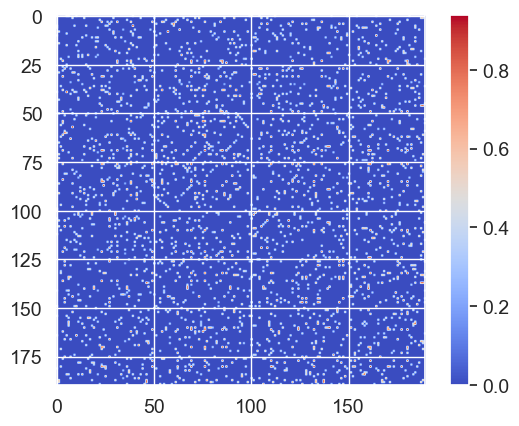

In [13]:
plt.imshow(np.array(compute_KNN_graph(A, 10)))
plt.colorbar()
plt.show()

## Creating the graphs

In [149]:
def create_graph(X_train, X_test, y_train, y_test):
    
    train_data = []
    val_data = []

    # Creating train data in pyG DATA structure
    for i in range((X_train.shape[0])):
        
        # Transforming into a correlation matrix
        Adj = correlation_matrix(190,X_train.iloc[i,:].values)     
        
        # Copying the Adj matrix for operations to define edge_index
        A = Adj.copy()
        
        Adj = torch.from_numpy(Adj).float()

        # Using k-NN to define Edges
        #A = compute_KNN_graph(A, 15)
        # Removing correlations inside of 1 std
        A[((A < 1.5*np.std(A.reshape(len(A)**2))) & (A > - 1.5*np.std(A.reshape(len(A)**2))))] = 0
                
        # Adding self connections
        np.fill_diagonal(A,1)
        A = torch.from_numpy(A).float()
        
        # getting the edge_index
        edge_index, edge_attr = dense_to_sparse(A)
        
        train_data.append(Data(x=Adj, edge_index=edge_index, y=torch.tensor(int(y_train.iloc[i]))))

          
    # Creating test data in pyG DATA structure
    for i in range((X_test.shape[0])):
        
        # Transforming into a correlation matrix
        Adj = correlation_matrix(190,X_test.iloc[i,:].values)     
        
        # Copying the Adj matrix for operations to define edge_index
        A = Adj.copy()
                
        Adj = torch.from_numpy(Adj).float()
        
        # Using k-NN to define Edges
        #A = compute_KNN_graph(A, 15)
        # Removing correlations inside of 1 std
        A[((A < 1.5*np.std(A.reshape(len(A)**2))) & (A > - 1.5*np.std(A.reshape(len(A)**2))))] = 0
        
        # Adding self connections
        np.fill_diagonal(A,1)
        A = torch.from_numpy(A).float()
        
        # getting the edge_index
        edge_index, edge_attr = dense_to_sparse(A)
        

        val_data.append(Data(x=Adj, edge_index=edge_index, y=torch.tensor(int(y_test.iloc[i]))))

    return train_data,val_data

In [150]:
train_data, val_data = create_graph(X_train, X_test, y_train, y_test)

In [151]:
print(train_data[0])

Data(x=[190, 190], edge_index=[2, 5124], y=1)


In [152]:
def create_batch(train_data, val_data, batch_size):
    
    train_loader = DataLoader(train_data, batch_size, shuffle=True)

    val_loader = DataLoader(val_data, shuffle=True)
    
    return train_loader, val_loader
    

In [153]:
train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)


In [156]:
import torch
import torch.nn.functional as func
from torch_geometric.nn import ChebConv, GCNConv, global_mean_pool

class GCN(torch.nn.Module):
    """GCN model(network architecture can be modified)"""

    def __init__(self,
                 num_features,
                 num_classes,
                 k_order,
                 dropout=.5):
        super(GCN, self).__init__()

        self.p = dropout
        
        self.conv1 = GCNConv(int(num_features), 64)
        #self.conv2 = GCNConv(64, 16)
        #self.conv3 = GCNConv(16, 2)
        
        #self.conv1 = ChebConv(int(num_features), 16, K=k_order)
        #self.conv2 = ChebConv(64, 32, K=k_order)
        #self.conv3 = ChebConv(64, 32, K=k_order)

        self.lin2 = torch.nn.Linear(64, 32)
        self.lin1 = torch.nn.Linear(32, int(num_classes))
        
        #self.max = torch.nn.Softmax(dim=1)
        self.pool = global_mean_pool

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch
        
        x = func.relu(self.conv1(x, edge_index )) #, edge_attr,batch))  #WHY NAN WITH EDGE_ATTR (non-negative)
        x = func.dropout(x, p=self.p, training=self.training)
        # x = func.relu(self.conv2(x, edge_index)) #, edge_attr, batch))  #WHY NAN WITH EDGE_ATTR (non-negative)
        # x = func.dropout(x, p=self.p, training=self.training)
        # x = func.relu(self.conv3(x, edge_index))  #, edge_attr, batch))  #WHY NAN WITH EDGE_ATTR (non-negative)
        # x = func.dropout(x, p=self.p, training=self.training)
        
        x = self.pool(x, batch)
        x = self.lin2(x)
        x = func.dropout(x, p=self.p, training=self.training)
        x = self.lin1(x)
        x = func.dropout(x, p=self.p, training=self.training)
        #x = self.max(x)
        return x

## K-fold cross validation

In [ ]:
from sklearn.model_selection import KFold

inputs = X_train
targets = y_train

loss_ = []
loss_test = []
acc_ = []

scores = np.zeros((4,5))
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    
    # creating the graphs
    train_data, val_data = create_graph(X_train.iloc[train], X_train.iloc[test],
                                         y_train.iloc[train], y_train.iloc[test])
    
    # creating the batchs inside the torch DataLoader
    train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)
    

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    
    # Train the NN Archithecture
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(190, 2, 3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    min_v_loss = np.inf  

    NUM_EPOCHS = 100
    for epoch in range(1,NUM_EPOCHS + 1):
        loop = tqdm(train_loader)
        t_loss = GCN_train(train_loader,loop)
        
        loss_.append(t_loss)
        
        test_sen, test_spe, test_acc, _ = GCN_test(val_loader)
        loss_test.append(_)
        acc_.append(test_acc)

    
    scores[0][fold_no - 1] = test_acc
    scores[1][fold_no - 1] = test_sen
    scores[2][fold_no - 1] = test_spe
    scores[3][fold_no - 1] = _

    print(f'Score for fold {fold_no}: loss of {_}; acc of {test_acc}%')

    # Increase fold number
    fold_no = fold_no + 1

In [ ]:
print('Average Accuracy in CV: {:.2f}({:.2f}) \n'.format(scores[0].mean(), scores[0].std()))
print('Average Sensitivity in CV: {:.2f}({:.2f}) \n'.format(scores[1].mean(), scores[1].std()))
print('Average Specificity in CV: {:.2f}({:.2f}) \n'.format(scores[2].mean(), scores[2].std()))
print('Average Loss in test CV: {:.2f}({:.2f}) \n'.format(scores[3].mean(), scores[3].std()))

In [ ]:
plt.plot(loss_)
plt.plot(loss_test)

# Testing in one fold

In [ ]:
def GCN_train(loader, loop):
    model.train()
    l1_weight = 1e-5
    loss_all = 0
    pred = []
    label = []
    
        
    for (x, y) in enumerate(loop):
        y = y.to(device)
        optimizer.zero_grad()
        output = model(y)
        #print(output)
        # Adding L1 regularization
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, y.y)
        loss_with_penalty = loss + l1_penalty
        loss_with_penalty.backward()
        optimizer.step()
        loss_all += y.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(y.y)

        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss_all)
        #optimizer.step()
    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
    return epoch_acc, loss_all / len(train_data)


def GCN_test(loader):
    model.eval()
    l1_weight = 1e-5
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, data.y)
        loss_with_penalty = loss + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_sen = tp / (tp + fn)
    epoch_spe = tn / (tn + fp)
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
    return epoch_sen, epoch_spe, epoch_acc, loss_all / len(val_data)

loss_ = []
loss_test = []
acc_test = []
acc_ = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(190, 2, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
   
min_v_loss = np.inf  

NUM_EPOCHS = 50
for epoch in range(1,NUM_EPOCHS + 1):
    loop = tqdm(train_loader)
    train_acc, train_loss = GCN_train(train_loader,loop)
    test_sen, test_spe, test_acc, _ = GCN_test(val_loader)
    
    loss_.append(train_loss)
    loss_test.append(_)
    acc_test.append(test_acc)
    acc_.append(train_acc)

    

Epoch [1/50]: 100%|███████████████████| 19/19 [00:01<00:00, 16.43it/s, loss=416]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_63926/884254374.py:56: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [2/50]: 100%|███████████████████| 19/19 [00:01<00:00, 18.56it/s, loss=406]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_63926/884254374.py:56: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [3/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.59it/s, loss=411]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_63926/884254374.py:56: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + fp)
Epoch [4/50]: 100%|███████████████████| 19/19 [00:00<00:00, 20.37it/s, loss=407]
/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ipykernel_63926/884254374.py:56: RuntimeWarning: invalid value encountered in scalar divide
  epoch_spe = tn / (tn + 

### Debug

In [ ]:
model.eval()

In [ ]:
y_pred = []
for y in val_loader:
    #y_pred.append(model(y).detach().numpy())
    y_pred.append(func.softmax(model(y), dim=1).detach().numpy())#.max(dim=1)[1])

In [ ]:
plt.hist(np.array(y_pred).reshape(len(y_pred)*2))
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(loss_, label='train')
ax.plot(loss_test, label='Validation')
ax.set_ylabel('Cross entropy loss')
ax.set_xlabel('Epochs')
ax.legend()
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(acc_, label='Training', linewidth=1,marker='.')
ax.plot(acc_test, label='validation', linewidth=1,marker='.')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.set_title('r = {:.2f}'.format(np.corrcoef(np.arange(0,len(acc_test)), acc_test)[0][1]))
ax.legend()
plt.show()
